In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Load the datasets
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')



In [162]:
# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())
print(engagements.head())
print(marketing.head())

   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

In [163]:
# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

In [164]:

# Check for missing values in the customers dataset
print(customers.isnull().sum())

# Fill missing values for gender with "Unknown"
customers['gender'].fillna('Unknown', inplace=True)

# Display columns with missing values
print(customers[customers.isnull().any(axis=1)])

customer_id              0
join_date                0
last_purchase_date       0
age                   1009
gender                 533
location                 0
dtype: int64
      customer_id  join_date last_purchase_date  age   gender  \
1               2 2021-09-08         2023-10-25  NaN     Male   
2               3 2021-06-01         2022-11-27  NaN  Unknown   
4               5 2022-01-24         2023-06-02  NaN     Male   
6               7 2023-12-11         2024-05-29  NaN   Female   
15             16 2023-05-06         2023-08-15  NaN     Male   
...           ...        ...                ...  ...      ...   
9936         9937 2020-03-11         2023-08-27  NaN   Female   
9956         9957 2023-01-11         2023-08-14  NaN  Unknown   
9978         9979 2023-12-30         2024-01-22  NaN   Female   
9989         9990 2023-06-08         2024-02-14  NaN   Female   
9994         9995 2020-08-06         2022-04-10  NaN     Male   

              location  
1            Hillvi

/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_61734/3049559131.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['gender'].fillna('Unknown', inplace=True)


In [165]:
# Extract the columns with missing values except gender
columns_with_missing_values = ['age']

# Perform KNN Imputation
imputer = KNNImputer(n_neighbors=5)
customers[columns_with_missing_values] = imputer.fit_transform(customers[columns_with_missing_values])

# Check if there are any remaining missing values
print(customers.isnull().sum())


customer_id           0
join_date             0
last_purchase_date    0
age                   0
gender                0
location              0
dtype: int64


In [166]:
# Display the rows that originally had missing values
print(customers[customers['customer_id'].isin([1, 2, 3, 4, 5])])

   customer_id  join_date last_purchase_date        age   gender  \
0            1 2023-11-20         2024-03-17  56.000000   Female   
1            2 2021-09-08         2023-10-25  43.467467     Male   
2            3 2021-06-01         2022-11-27  43.467467  Unknown   
3            4 2022-01-01         2022-09-01  29.000000     Male   
4            5 2022-01-24         2023-06-02  43.467467     Male   

            location  
0  North Shannonbury  
1          Hillville  
2   North Latoyatown  
3          Grossstad  
4   East Matthewfort  


In [167]:
# Now the missing value is filled

In [168]:
# Merge datasets on customer_id
data = pd.merge(transactions, customers, on='customer_id')
data = pd.merge(data, engagements, on='customer_id')
data = pd.merge(data, marketing, on='customer_id')

# Convert dates to datetime format
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['join_date'] = pd.to_datetime(data['join_date'])
data['last_purchase_date'] = pd.to_datetime(data['last_purchase_date'])

# Calculate customer lifespan in months
data['customer_lifespan'] = ((data['last_purchase_date'] - data['join_date']).dt.days / 30).apply(np.ceil).astype(int)
data['customer_lifespan'] = data['customer_lifespan'].apply(lambda x: max(x, 1))

# Calculate CLV (sum of all transactions per customer)
customer_clv = data.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_clv.columns = ['customer_id', 'CLV']

# Merge the CLV back to the customers dataframe
customers = pd.merge(customers, customer_clv, on='customer_id')

# Calculate CLV per month
customers = pd.merge(customers, data[['customer_id', 'customer_lifespan']].drop_duplicates(), on='customer_id')
customers['CLV_per_month'] = customers['CLV'] / customers['customer_lifespan']







In [169]:
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location,CLV,customer_lifespan,CLV_per_month
0,1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,14037.92,4,3509.480000
1,2,2021-09-08,2023-10-25,43.467467,Male,Hillville,24325.28,26,935.587692
2,3,2021-06-01,2022-11-27,43.467467,Unknown,North Latoyatown,2909.74,19,153.144211
3,4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,31498.72,9,3499.857778
4,5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,62098.20,17,3652.835294


In [170]:
# Calculate total CLV per month
total_clv_per_month = customers['CLV_per_month'].sum()

# Sort customers by CLV per month in descending order
customers = customers.sort_values(by='CLV_per_month', ascending=False)

# Calculate cumulative sum of CLV per month and identify high-value customers
customers['cumulative_clv_per_month'] = customers['CLV_per_month'].cumsum()
customers['percent_of_total_clv'] = customers['cumulative_clv_per_month'] / total_clv_per_month

# Classify high-value customers (top 80% of total CLV per month)
customers['Is_high_value_customer'] = customers['percent_of_total_clv'] <= 0.8


In [171]:
customers.head()


,customer_id,join_date,last_purchase_date,age,gender,location,CLV,customer_lifespan,CLV_per_month,cumulative_clv_per_month,percent_of_total_clv,Is_high_value_customer
3822,3823,2022-11-29,2022-12-29,60.000000,Male,Monicaburgh,82406.76,1,82406.76,82406.76,0.001924,True
6876,6877,2023-07-14,2023-07-14,43.467467,Female,Garystad,74802.00,1,74802.00,157208.76,0.003671,True
2641,2642,2020-06-16,2020-06-26,20.000000,Female,Kurtchester,74736.88,1,74736.88,231945.64,0.005416,True
5825,5826,2024-05-20,2024-05-30,45.000000,Male,Aprilport,69442.72,1,69442.72,301388.36,0.007038,True
9424,9425,2024-01-25,2024-02-02,43.467467,Female,Kennethhaven,68155.88,1,68155.88,369544.24,0.008630,True


In [172]:
# Calculate "recency" and "usage_lifespan"
customers['recency'] = (last_transaction_date - customers['last_purchase_date']).dt.days
customers['usage_lifespan'] = (last_transaction_date - customers['join_date']).dt.days

# Calculate "frequency"
frequency = transactions.groupby('customer_id')['transaction_id'].count().reset_index()
frequency.columns = ['customer_id', 'frequency']

# Merge "frequency" with customers
customers = pd.merge(customers, frequency, on='customer_id')

# Calculate "positive_response_per_transaction"
positive_responses = marketing[marketing['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_responses')
customers = pd.merge(customers, positive_responses, on='customer_id', how='left')
customers['positive_responses'].fillna(0, inplace=True)
customers['positive_response_per_transaction'] = customers['positive_responses'] / customers['frequency']

# Calculate "site_per_transaction"
engagement_data = engagements.groupby('customer_id').sum().reset_index()
customers = pd.merge(customers, engagement_data[['customer_id', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks']], on='customer_id')
customers['site_per_transaction'] = customers['number_of_site_visits'] / customers['frequency']

# Calculate "email_per_transaction"
customers['email_per_transaction'] = customers['number_of_emails_opened'] / customers['frequency']

# Calculate "click_per_transaction"
customers['click_per_transaction'] = customers['number_of_clicks'] / customers['frequency']

# Drop temporary columns
customers.drop(columns=['positive_responses', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks'], inplace=True)






/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_61734/2426913939.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['positive_responses'].fillna(0, inplace=True)


In [173]:
customers.describe()

,customer_id,join_date,last_purchase_date,age,CLV,customer_lifespan,CLV_per_month,cumulative_clv_per_month,percent_of_total_clv,recency,usage_lifespan,frequency,positive_response_per_transaction,site_per_transaction,email_per_transaction,click_per_transaction
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2022-03-19 09:28:13.439999744,2023-04-25 18:26:12.480000256,43.467467,19523.073123,13.906100,4282.213157,3.606391e+07,0.842179,401.231800,803.60540,12.954500,0.192833,15.944076,6.300875,3.092276
min,1.00000,2020-01-01 00:00:00,2020-01-26 00:00:00,18.000000,23.810000,1.000000,0.643514,8.240676e+04,0.001924,0.000000,0.00000,1.000000,0.000000,0.040000,0.040000,0.040000
25%,2500.75000,2021-02-15 00:00:00,2022-09-19 00:00:00,32.000000,7469.732500,4.000000,562.931146,3.343975e+07,0.780899,110.000000,399.00000,7.000000,0.041667,1.320000,0.526316,0.291667
50%,5000.50000,2022-03-19 00:00:00,2023-08-04 00:00:00,43.467467,15188.355000,10.000000,1493.674556,3.971030e+07,0.927331,301.000000,804.00000,13.000000,0.090909,4.848077,2.000000,1.000000
75%,7500.25000,2023-04-28 00:00:00,2024-02-11 00:00:00,55.000000,28304.627500,21.000000,4140.411364,4.212377e+07,0.983692,620.000000,1201.00000,19.000000,0.187500,14.000000,5.666667,2.764706
max,10000.00000,2024-05-31 00:00:00,2024-05-31 00:00:00,69.000000,82406.760000,53.000000,82406.760000,4.282213e+07,1.000000,1587.000000,1612.00000,25.000000,4.000000,684.000000,298.000000,113.000000
std,2886.89568,NaN,NaN,14.312544,15482.860504,11.844607,7815.371122,8.679355e+06,0.202684,352.433262,466.24581,7.191203,0.361048,39.410611,15.256806,7.251774


In [174]:
# Define numerical and categorical columns
numerical_columns = ['age', 'recency', 'frequency', 'usage_lifespan', 'positive_response_per_transaction', 'site_per_transaction', 'email_per_transaction', 'click_per_transaction']
categorical_columns = ['gender']

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Fit and transform the data
preprocessed_data = preprocessor.fit_transform(customers)

# Convert the preprocessed data back to a DataFrame for ease of use
preprocessed_df = pd.DataFrame(preprocessed_data, columns=numerical_columns + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)))
print(preprocessed_df.head())




        age   recency  frequency  usage_lifespan  \
0  0.823529  0.327032   0.875000        0.340571   
1  0.499362  0.202899   0.958333        0.199752   
2  0.039216  0.904222   0.958333        0.896402   
3  0.529412  0.000630   1.000000        0.006824   
4  0.499362  0.074984   0.958333        0.078784   

   positive_response_per_transaction  site_per_transaction  \
0                           0.034091              0.000673   
1                           0.031250              0.000002   
2                           0.020833              0.000124   
3                           0.030000              0.000175   
4                           0.000000              0.000063   

   email_per_transaction  click_per_transaction  gender_Female  gender_Male  \
0               0.000018               0.000451            0.0          1.0   
1               0.000006               0.000015            1.0          0.0   
2               0.000006               0.000015            1.0          0.0  

In [175]:
preprocessed_data

array([[0.82352941, 0.32703214, 0.875     , ..., 0.        , 1.        ,
        0.        ],
       [0.49936211, 0.20289855, 0.95833333, ..., 1.        , 0.        ,
        0.        ],
       [0.03921569, 0.9042218 , 0.95833333, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.74509804, 0.15500945, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49936211, 0.21991178, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.7254902 , 0.07939509, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [176]:
# Define features (X) and target (y)
X = customers[['age', 'recency', 'frequency', 'usage_lifespan', 'positive_response_per_transaction', 'site_per_transaction', 'email_per_transaction', 'click_per_transaction', 'gender']]
y = customers['Is_high_value_customer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
nb = GaussianNB()

# Create pipelines
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', logreg)])
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', knn)])
nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', nb)])

# Cross-validation to determine which model works best
logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, scoring='f1', cv=5)
knn_scores = cross_val_score(knn_pipeline, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb_pipeline, X_train, y_train, scoring='f1', cv=5)

print(f'Logistic Regression Mean F1 Score: {np.mean(logreg_scores)}')
print(f'K-Nearest Neighbors Mean F1 Score: {np.mean(knn_scores)}')
print(f'Naive Bayes Mean F1 Score: {np.mean(nb_scores)}')

# Select the best model based on highest F1 score
best_model_pipeline = None
best_model_name = ''
best_f1_score = 0

if np.mean(logreg_scores) > best_f1_score:
    best_f1_score = np.mean(logreg_scores)
    best_model_pipeline = logreg_pipeline
    best_model_name = 'Logistic Regression'

if np.mean(knn_scores) > best_f1_score:
    best_f1_score = np.mean(knn_scores)
    best_model_pipeline = knn_pipeline
    best_model_name = 'K-Nearest Neighbors'

if np.mean(nb_scores) > best_f1_score:
    best_f1_score = np.mean(nb_scores)
    best_model_pipeline = nb_pipeline
    best_model_name = 'Naive Bayes'

print(f'Best Model: {best_model_name} with F1 Score: {best_f1_score}')

Logistic Regression Mean F1 Score: 0.8012358612879666
K-Nearest Neighbors Mean F1 Score: 0.7389347504934322
Naive Bayes Mean F1 Score: 0.7373263282186132
Best Model: Logistic Regression with F1 Score: 0.8012358612879666


In [177]:
# Fit the best model on the training data
best_model_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model_pipeline.predict(X_test)

# Calculate and print the F1 score for the test data
final_f1_score = f1_score(y_test, y_pred)
print(f'Final F1 Score on Test Data: {final_f1_score}')

Final F1 Score on Test Data: 0.806609547123623


In [178]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.8946666666666667
0.806609547123623
0.82375
0.790167865707434


In [179]:
# Hyperparameter tuning for Logistic Regression
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': [100, 200, 300, 500],
    'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

grid_search_logreg = GridSearchCV(logreg_pipeline, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

print(f'Best Params for Logistic Regression: {grid_search_logreg.best_params_}')
logreg_best = grid_search_logreg.best_estimator_

# Cross-validation for KNN and Naive Bayes
knn_scores = cross_val_score(knn_pipeline, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb_pipeline, X_train, y_train, scoring='f1', cv=5)

print(f'Logistic Regression Mean F1 Score: {np.mean(grid_search_logreg.cv_results_["mean_test_score"])}')
print(f'K-Nearest Neighbors Mean F1 Score: {np.mean(knn_scores)}')
print(f'Naive Bayes Mean F1 Score: {np.mean(nb_scores)}')

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

Best Params for Logistic Regression: {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Logistic Regression Mean F1 Score: nan
K-Nearest Neighbors Mean F1 Score: 0.7389347504934322
Naive Bayes Mean F1 Score: 0.7373263282186132


In [180]:
logreg_new = LogisticRegression(C=10, l1_ratio=0, max_iter=100, penalty='l1', solver='liblinear')
logreg_pipeline_new = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', logreg_new)])
logreg_scores_new = cross_val_score(logreg_pipeline_new, X_train, y_train, scoring='f1', cv=5)
best_f1_score1 = np.mean(logreg_scores_new)
best_model_pipeline = logreg_pipeline_new



# Fit the best model on the training data
best_model_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model_pipeline.predict(X_test)

# Calculate and print the F1 score for the test data
final_f1_score = f1_score(y_test, y_pred)
print(f'Final F1 Score on Test Data: {final_f1_score}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

Final F1 Score on Test Data: 0.8314868804664723


In [181]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.9036666666666666
0.8314868804664723
0.8093076049943246
0.854916067146283


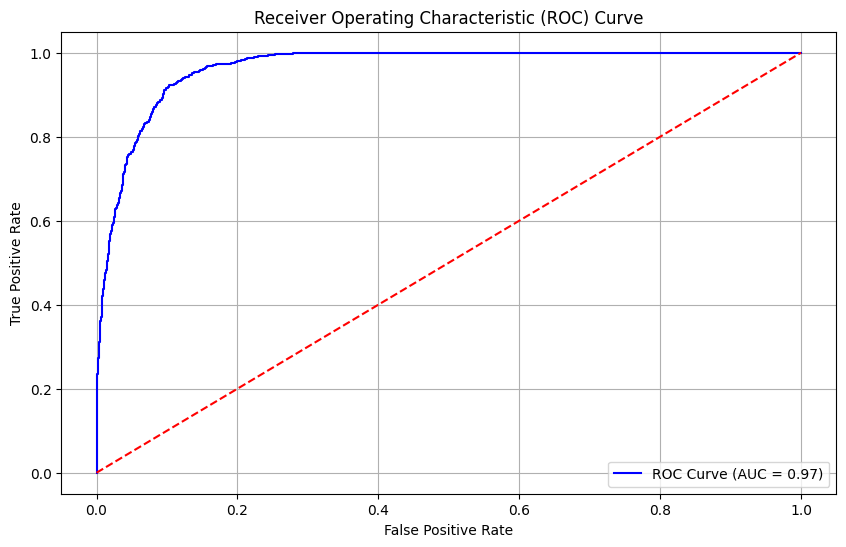

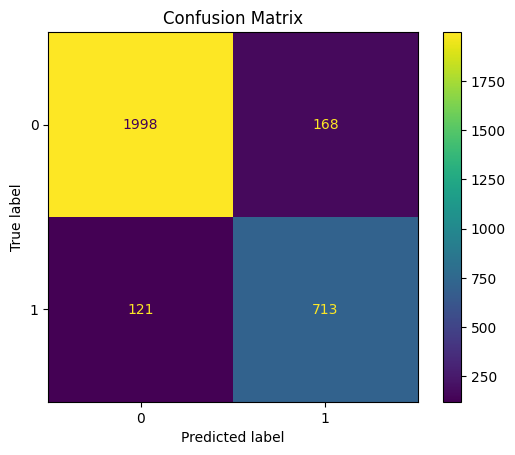

In [182]:
# Calculate ROC curve and AUC
y_pred_prob = best_model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix')
plt.show()